In [ ]:
'''
DQN 算法敲开了深度强化学习的大门，但是作为先驱性的工作，其本身存在着一些问题以及一些可以改进的地方。
于是，在 DQN 之后，学术界涌现出了非常多的改进算法。
'''
'''
本章将介绍其中两个非常著名的算法：Double DQN 和 Dueling DQN
'''

# Double DQN

### 普通的 DQN 算法通常会导致对Q值的过高估计（overestimation）。传统 DQN 优化的 TD 误差目标为
$ r + γmax_{a`}Q_{w^-{(s`,a`)}}$

其中的$max_{a`}Q_{w^-{(s`,a`)}}$ 由目标网络计算得出，可以将其写成如下形式：
$Q_{w^-}(s`,argmax_{a`}Q_{w^-}{(s`,a`)})$
换句话说，max操作实际可以被拆解为两部分：
#### 首先选取状态s`下的最优动作: 
$ a^* = argmax_{a^`}{Q_{w^-}{(s`,a`)}} $
#### 接着计算该动作对应的价值:
$ Q_{w^-}{(s`,a`)} $

当这两部分采用同一套 Q 网络进行计算时，**每次得到的都是神经网络当前估算的所有动作价值中的最大值。考虑到通过神经网络估算的Q值本身在某些时候会产生正向或负向的误差**，在 DQN 的更新方式下神经网络会将正向误差累积。

对于动作空间较大的任务，DQN 中的过高估计问题会非常严重，造成 DQN 无法有效工作的后果。

**为了解决这一问题，Double DQN 算法提出利用两个独立训练的神经网络估算:**
$ max_{a`}Q_{w^-{(s`,a`)}}$

具体做法是:利用一套神经网络$ Q_w $ 的输出选取价值最大的动作，使用另一套神经网络$ Q_w^{-} $ 计算该动作的价值。即：
将原来的$ max_{a`}Q_{w^-{(s`,a`)}}$ 更改为 $ Q_{w^-}(s`,argmax_{a^`}{Q_{w}{(s`,a`)}}) $

**这样，即使其中一套神经网络的某个动作存在比较严重的过高估计问题，由于另一套神经网络的存在，这个动作最终使用的Q值不会存在很大的过高估计问题。**

在传统的 DQN 算法中，本来就存在两套函数的神经网络——目标网络和训练网络,只不过 $ max_{a`}Q_{w^-{(s`,a`)}}$ 的计算只用到了其中的目标网络,那么我们恰好可以直接将训练网络作为 Double DQN 算法中的第一套神经网络来选取动作，将目标网络作为第二套神经网络计算Q值，这便是 Double DQN 的主要思想。

在 DQN 算法中将训练网络的参数记为$w$，将目标网络的参数记为$w^-$，这与本节中 Double DQN 的两套神经网络的参数是统一的，因此，我们可以直接写出如下 Double DQN 的优化目标：
$ r + γQ_{w^-}(s`,argmax_{a^`}{Q_{w}{(s`,a`)}}) $

DQN 与 Double DQN 的差别只是在于计算状态s`下Q值时如何选取动作：
- DQN 的优化目标可以写为：$ r + γQ_{w^-}(s`,argmax_{a^`}{Q_{w^-}{(s`,a`)}}) $，动作的选取依靠目标网络；
- Double DQN 的优化目标为：$ r + γQ_{w^-}(s`,argmax_{a^`}{Q_{w}{(s`,a`)}}) $，动作的选取依靠训练网络。

In [2]:
import random
import gym
import numpy as np
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils
from tqdm import tqdm
from IPython.display import Image

class Qnet(torch.nn.Module):
    def __init__(self,state_dim,hidden_dim,action_dim):
        super(Qnet,self).__init__()
        self.fc1 = torch.nn.Linear(state_dim,hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim,action_dim)
    def forward(self,x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [4]:
class DQN:
    def __init__(self,
                 state_dim,
                 hidden_dim,
                 action_dim,
                 learning_rate,
                 gamma,
                 epsilon,
                 target_update,
                 device,dqn_type='VanillaDQN'):
        self.action_dim = action_dim
        self.q_net = Qnet(state_dim,hidden_dim,self.action_dim).to(device)
        self.target_q_net = Qnet(state_dim,hidden_dim,self.action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.q_net.parameters(),lr=learning_rate)
        self.gamma = gamma
        self.epsilon = epsilon
        self.target_update = target_update
        self.count = 0
        self.dqn_type = dqn_type
        self.device = device
    def take_action(self,state):
        if np.random.random < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor([state],dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item()
        return action
    
    def max_q_value(self,state):
        state = torch.tensor([state],dtype=torch.float).to(self.device)
        return self.q_net(state).max().item()
        
    def update(self,transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)
        q_values = self.q_net(states).gather(1, actions)  # Q值
        # 下一个状态的最大Q值
        if self.dqn_type == 'DoubleDQN' : 
            max_action = self.q_net(next_states).max(1)[1].view(-1,1) # 使用q_net
            max_next_q_values = self.target_q_net(next_states).gather(1,max_action) # 使用目标网络
        else:
            max_next_q_values = self.target_q_net(next).max(1)[0].view(-1,1)
        #计算TD目标
        q_targets = rewards +  self.gamma * max_next_q_values *(1-dones)
        # 均方误差损失函数
        dqn_loss = torch.mean(F.mse_loss(q_values,q.targets))
        self.optimizer.zero_grad()
        dqn_loss.backward()# 反向传播更新参数
        self.optimizer.step()
        
        # 更新目标网络的频率
        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict())
        self.count+=1

In [6]:
'''
相应的超参数，并实现将倒立摆环境中的连续动作转化为离散动作的函数。
'''
lr = 1e-2
num_episodes = 200
hidden_dim = 128
gamma = 0.98
epsilon = 0.01
target_update = 50 # 每50次更新一次目标网络
buffer_size = 5000
batch_size = 64

device = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')

env_name = 'Pendulum-v1'
env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = 11 # 将连续动作分为11个离散动作

# 离散动作转回连续动作
# discrete_action 离散动作索引
def dis_to_con(discrete_action,env,action_dim):
    action_lowbound = env.action_space.low[0] # 连续动作的最小值
    action_upbound = env.action_space.high[0] # 连续动作的最大值
    return action_lowbound + (discrete_action / (action_dim - 1)) * (action_upbound - action_lowbound)

'''
discrete_action / (action_dim - 1): 将离散动作索引归一化到 [0, 1] 范围内。action_dim - 1 是离散动作索引的最大值。
(action_upbound - action_lowbound): 计算连续动作空间的范围。
action_lowbound + ...: 将归一化的离散动作映射到连续动作空间中。
'''


'\ndiscrete_action / (action_dim - 1): 将离散动作索引归一化到 [0, 1] 范围内。action_dim - 1 是离散动作索引的最大值。\n(action_upbound - action_lowbound): 计算连续动作空间的范围。\naction_lowbound + ...: 将归一化的离散动作映射到连续动作空间中。\n'

In [ ]:
'''
接下来要对比 DQN 和 Double DQN 的训练情况

训练过程会记录下每个状态的最大Q值，在训练完成后我们可以将结果可视化，
观测这些Q值存在的过高估计的情况，以此来对比 DQN 和 Double DQN 的不同。
'''
def  train_DQN(agent,env,num_episodes,replay_buffer,minimal_size,batch_size):
    return_list = []
    max_q_value_list = []
    max_q_value = 0
    for i in range(10):
        with tqdm(total =int(num_episodes / 10),desc='Iteration %d' % i ) as pbar:
            for i_episode in range(int(num_episodes / 10)):
                episode_return = 0
                state = env.reset()
                done = False
                while not done:
                    action = agent.take_action(state)
                    # 新值对结果影响较小0.005，旧值对结果影响较大0.995
                    max_q_value = agent.max_q_value(state) * 0.005 + max_q_value * 0.995 # 平滑处理
                    # 保存每个状态下，经过平滑处理后的最大Q值
                    max_q_value_list.append(max_q_value)
                    action_continuos = dis_to_con(action,env,agent.action_dim)
                    
                    next_state,reward,done,_ = env.step([action_continuos])
                    # 添加到replay buffer中
                    replay_buffer.append(state,action,reward,next_state,done)
                    
                    state = next_state
                    episode_return +=reward
                    
                    if replay_buffer.size() > minimal_size: # 达到指定容量之后才能使用
                        b_s,b_a,a_r,b_ns,b_d = replay_buffer.sample(batch_size)
                        transition_dict = {
                            'states':b_s,
                            'actions':b_a,
                            'next_states':b_ns,
                            'rewards':b_r,
                            'dones':b_ds
                        }
                        agent.update(transition_dict)
                return_list.append(episode_return)
                if(i_episode +1) % 10 ==0:
                    pbar.set_postfix({
                        'episode': '%d' %(num_episodes / 10 * i + i_episode + 1),
                        'return':'%.3f' %np.mean(return_list[-10:])
                    })
                pbar.update(10)
        return return_list,max_q_value_list

In [ ]:
'''
一切就绪！我们首先训练 DQN 并打印出其学习过程中最大Q值的情况。
'''

random.seed(0)
np.random.seed(0)
env.seed(0)
torch.manul_seed(0)

replay_buffer = rl_utils.replay_buffer(buffer_size)
agent = DQN(state_dim,hidden_dim,action_dim,lr,gamma,epsilon,target_update,device)
return_list,max_q_value_list = train_DQN(agent,env,num_episodes,replay_buffer,minimal_size,batch_size)

episodes_list = list(range(len(return_list)))
mv_return = rl_utils.moving_average(return_list,5)
plt.plot(episodes_list,mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

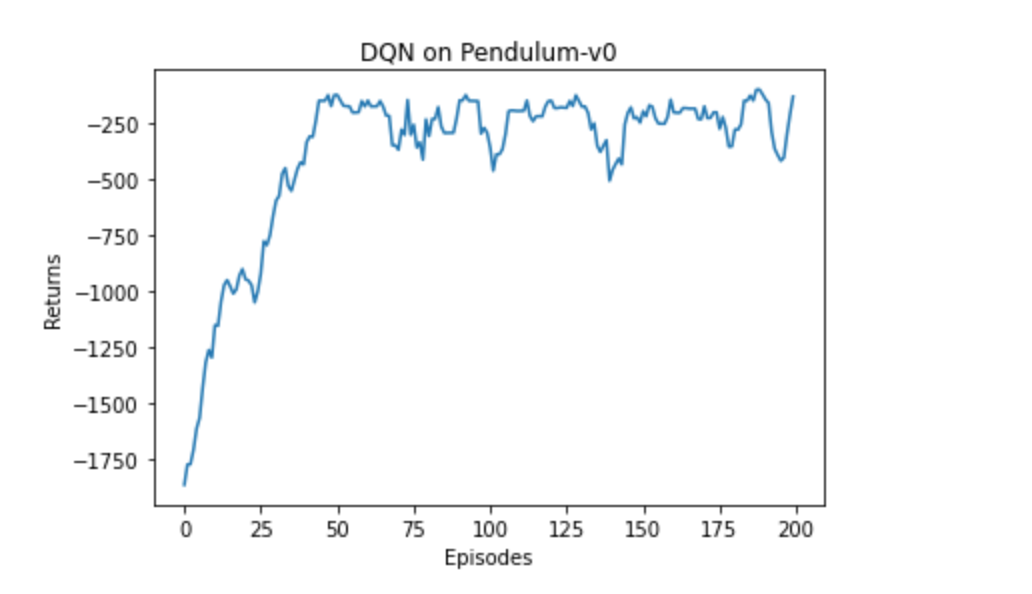

In [9]:
Image(filename="./returns.png")
'''
DQN 算法在倒立摆环境中能取得不错的回报，最后的期望回报在-200 左右
'''

In [ ]:
frames_list = list(range(len(max_q_value_list)))
plt.axhline(0,c='orange',ls='--')
plt.axhline(0,c='red',ls='--')
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title('DQN on {}'.format(env_name))
plt.show()

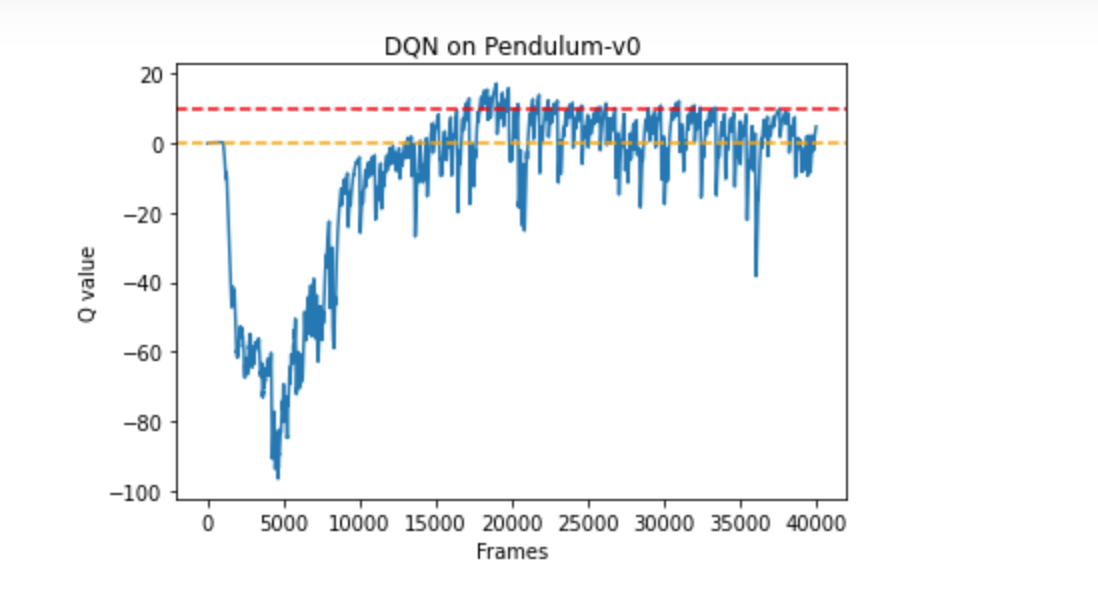

In [10]:
Image(filename='./value.png')
'''
不少值超过了 0，有一些还超过了 10，该现象便是 DQN 算法中的值过高估计
'''

In [3]:
'''
我们现在来看一下 Double DQN 是否能对此问题进行改善
'''

random.seed(0)
np.random.seed(0)
env.seed(0)
torch.manual_seed(0)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device, 'DoubleDQN')
return_list, max_q_value_list = train_DQN(agent, env, num_episodes,
                                          replay_buffer, minimal_size,
                                          batch_size)

episodes_list = list(range(len(return_list)))
mv_return = rl_utils.moving_average(return_list, 5)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Double DQN on {}'.format(env_name))
plt.show()

frames_list = list(range(len(max_q_value_list)))
plt.plot(frames_list, max_q_value_list)
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title('Double DQN on {}'.format(env_name))
plt.show()

NameError: name 'env' is not defined

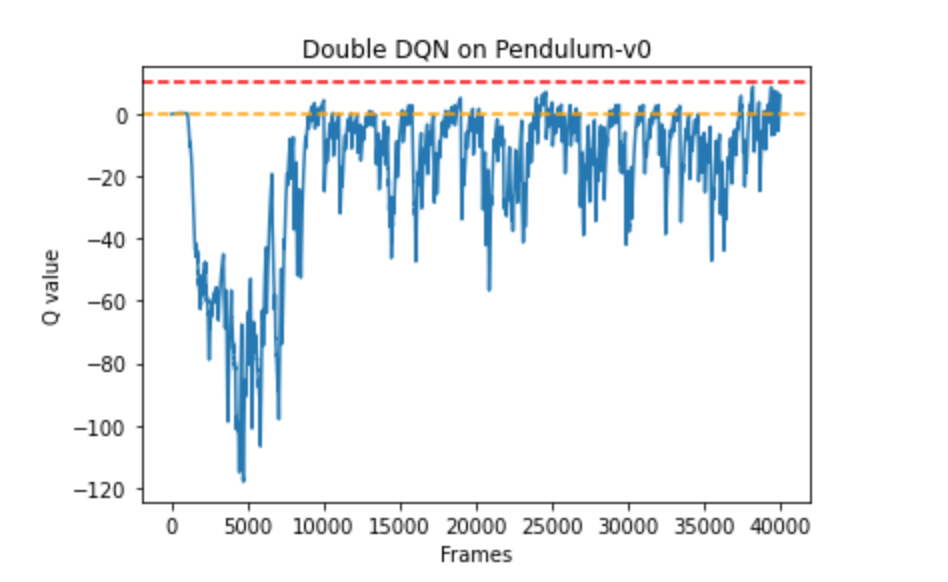

In [11]:
Image(filename='./value2.png')
'''
与普通的 DQN 相比，Double DQN 比较少出现Q值大于 0 的情况，说明Q值过高估计的问题得到了很大缓解。
'''

# Dueling DQN

Dueling DQN 是 DQN 另一种的改进算法，它在传统 DQN 的基础上只进行了微小的改动，但却能大幅提升 DQN 的表现。
在强化学习中，我们将状态动作价值函数减去状态价值函数的结果定义为优势函数A，即 $A(s,a) = Q(s,a) - V(s)$

在同一个状态下，所有动作的优势值之和为 0，因为所有动作的动作价值的期望就是这个状态的状态价值。
据此，在 Dueling DQN 中，Q 网络被建模为：
$Q_{n,a,β}{(s,a)} = V_{n,a}(s) + A_{n,β}(s,a)$

$ A_{n,β}(s,a)$ 为该状态下采取不同动作的优势函数，表示采取不同动作的差异性。

$n$是状态价值函数和优势函数共享的网络参数，一般用在神经网络中，用来提取特征的前几层；

a和β分别为状态**价值函数**和**优势函数**的参数

在这样的模型下，我们不再让神经网络直接输出Q值，而是训练神经网络的最后几层的两个分支，分别输出**状态价值函**和**优势函数**，再求和得到Q值。



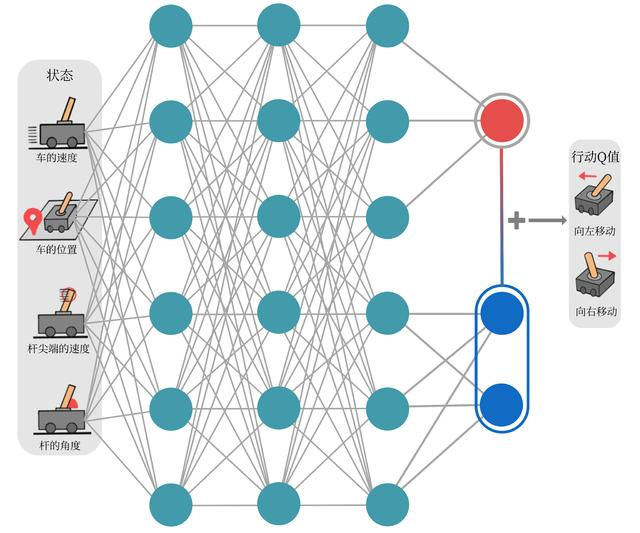

In [12]:
Image(filename="./d_dqn.png")

**将状态价值函数和优势函数分别建模的好处在于：**
某些情境下智能体只会关注状态的价值，而并不关心不同动作导致的差异，**此时将二者分开建模能够使智能体更好地处理与动作关联较小的状态**。

在图 8-3 所示的驾驶车辆游戏中，智能体注意力集中的部位被显示为橙色（另见彩插图 4），
- 当智能体前面没有车时，车辆自身动作并没有太大差异，此时智能体更关注状态价值，
- 当智能体前面有车时（智能体需要超车），智能体开始关注不同动作优势值的差异。



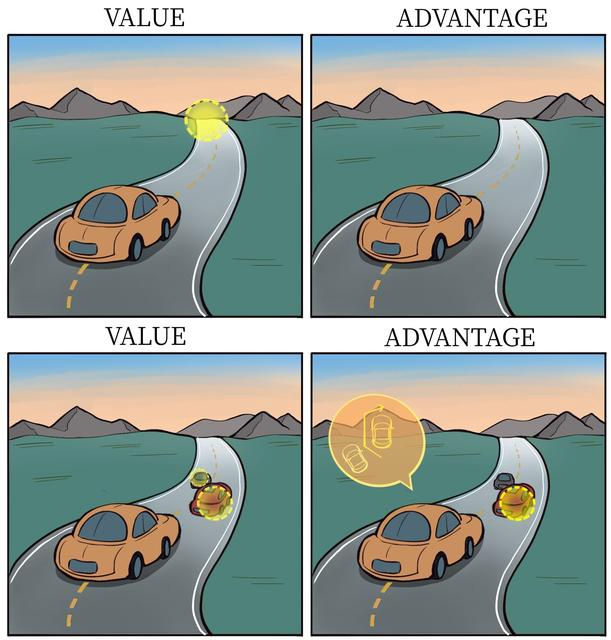

In [16]:
'''
状态价值 和 优势值 的简单例子
'''
Image(filename="./car.png")


**对于 Dueling DQN 中的公式 $Q_{n,a,β}{(s,a)} = V_{n,a}(s) + A_{n,β}(s,a)$，它存在对于 V值 和 A值 建模不唯一性的问题:**

例如，对于同样的Q值，如果将V值加上任意大小的常数C，再将所有A值减去C，**则得到的值依然不变**，这就导致了训练的不稳定性。

** 为了解决这一问题，Dueling DQN 强制最优动作的优势函数的实际输出为 0，即：**

$Q_{n,a,β}{(s,a)} = V_{n,a}(s) + A_{n,β}(s,a) -max_{a`}{A_{n,β}{(s,a`)}}$

此时$V(s) = max_a{Q(s,a)}$ 可以确保V值建模的唯一性

在实现过程中，我们还可以用平均代替最大化操作，即：


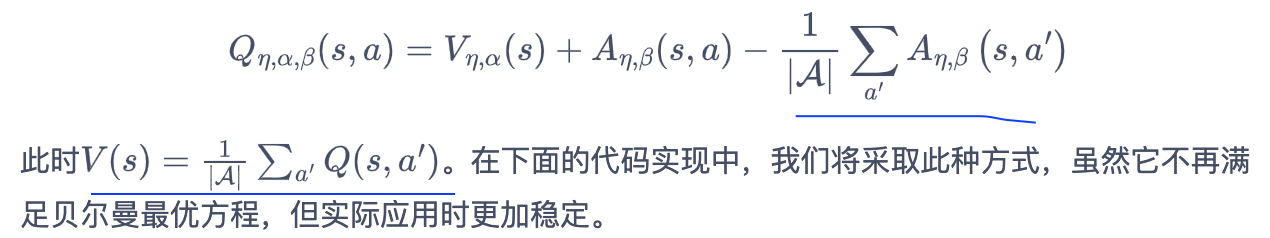

In [17]:
Image(filename='./mean.png')

**有的读者可能会问：“为什么 Dueling DQN 会比 DQN 好？**

”部分原因在于 Dueling DQN 能更高效学习状态价值函数。每一次更新时，函数V都会被更新，这也会影响到其他动作的Q值。而传统的 DQN 只会更新某个动作的Q值，其他动作的Q值就不会更新。

因此，Dueling DQN 能够更加频繁、准确地学习状态价值函数。

In [22]:
'''
Dueling DQN 与 DQN 相比的差异只是在网络结构上，大部分代码依然可以继续沿用。
我们定义状态价值函数和优势函数的复合神经网络VAnet。
'''
class VAnet(torch.nn.Module):
    def __init__(state_dim,hidden_dim,action_dim):
        super(VAnet,self).__init__()
        self.fc1 = torch.nn.Linear(state_dim,hidden_dim)# 共享网络
        self.fc_A = torch.nn.Linear(hidden_dim,action_dim)
        self.fc_V = torch.nn.Linear(hidden_dim,1)
    def forward(self,x):
        A = self.fc_A(F.relu(self.fc1(x)))
        V = self.fc_V(F.relu(self.fc1(x)))
        Q = V + A  - A.mean(1).view(-1,1)
        return Q
    
'''DQN算法，包括Double DQN 和 Dueling DQN'''
class DDQN:
    def __init__(state_dim,hidden_dim,action_dim,learing_rate,gamma,epsilon,target_update,device,dqn_type='VanillaDQN'):
        self.action_dim = action_dim
        if dqn_type == 'DuelingDQN': # Dueling DQN采取不一样的网络架构
            self.q_net = VAnet(state_dim,hidden_dim,self.action_dim).to(device) # Q网络
            self.target_q_net = VAnet(state_dim,hidden_dim,self.action_dim).to(device) # 目标网络
        else:
            self.q_net = Qnet(state_dim,hidden_dim,self.action_dim).to(device)
            self.target_q_net = Qnet(state_dim,hidden_dim,self.action_dim).to(device)
            
        self.optimizer  = torch.optim.Adam(self.q_net.parameters(),lr=learing_rate)
        self.gamma = gamma
        self.epsilon = epsilon
        self.target_update = target_update
        self.count =0
        self.dqn_type = dqn_type
        self.device = device
        
    def take_action(self,state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor([state],dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item()
        return action
    
    def max_q_value(self,state):
        state = torch.tensor(transition_dict['states'],dtype=torch.float).to(self.device)
        return self.q_net(state).max().item()
    
    def update(self,transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)
        q_values = self.q_net(states).gather(1,actions)
        
        if self.dqn_type =='DoubleDQN':# 这种方法可以减少 Q 值的高估问题
            # 使用主网络选择动作
            max_action = self.q_net(next_states).max(1)[1].view(-1,1)
            # 然后使用目标网络评估该动作的Q值
            max_next_q_values = self.target_q_net(next_states).gather(1,max_action)
        else:
            # 直接使用目标网络计算下一个状态的最大Q值
            max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1,1)
        
        # TD目标
        q_targets = rewards + self.gamma *  max_next_q_values * (1 - dones)
        # 计算损失
        dqn_loss = torch.mean(F.mse_loss(q_values,q_targets))
        self.optimizer.zero_grad()
        dqn_loss.backward()
        self.optimizer.step()
        
        if self.count % self.target_update ==0:# 更新目标网络
            self.target_q_net.load_state_dict(self.q_net.state_dict())

random.seed(0)
np.random.seed(0)
env.seed(0)
torch.manual_seed(0)

replay_buffer = rl_utils.replay_buffer(buffer_size)
agent = DDQN(state_dim,hidden_dim,action_dim,lr,gamma,epsilon,target_update,device,'DuelingDQN')
retur_list,max_q_value_list = train_DQN(agent,env,num_episodes,replay_buffer,minimal_size,batch_size)

episodes_list = list(range(len(return_list)))
mv_return = rl_utils.moving_average(return_list, 5)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Dueling DQN on {}'.format(env_name))
plt.show()

frames_list = list(range(len(max_q_value_list)))
plt.plot(frames_list, max_q_value_list)
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title('Dueling DQN on {}'.format(env_name))
plt.show()


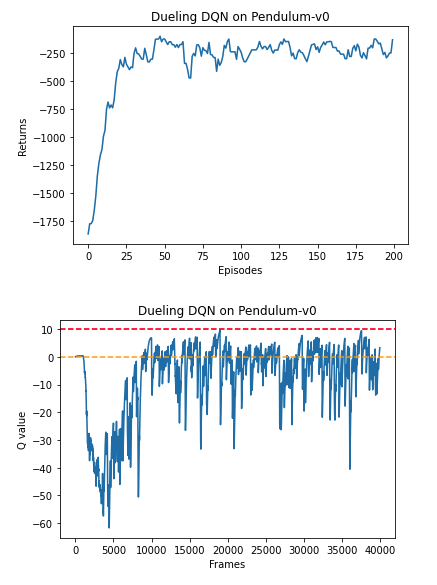

In [23]:
Image(filename="./ddqn.png")

根据代码运行结果我们可以发现，相比于传统的 DQN，Dueling DQN 在多个动作选择下的学习更加稳定，得到的回报最大值也更大。

由 Dueling DQN 的原理可知，随着动作空间的增大，Dueling DQN 相比于 DQN 的优势更为明显。

之前我们在环境中设置的离散动作数为 11，我们可以增加离散动作数（例如 15、25 等），继续进行对比实验。



在传统的 DQN 基础上，有两种非常容易实现的变式——Double DQN 和 Dueling DQN，

Double DQN 解决了 DQN 中对值的过高估计，而 Dueling DQN 能够很好地学习到不同动作的差异性，在动作空间较大的环境下非常有效。

**从 Double DQN 和 Dueling DQN 的方法原理中，我们也能感受到深度强化学习的研究是在关注深度学习和强化学习有效结合**
- 一是在深度学习的模块的基础上，强化学习方法如何更加有效地工作，并避免深度模型学习行为带来的一些问题，例如使用 Double DQN 解决值过高估计的问题；

- 二是在强化学习的场景下，深度学习模型如何有效学习到有用的模式，例如设计 Dueling DQN 网络架构来高效地学习状态价值函数以及动作优势函数。

#  扩展阅读： 对 Q 值过高估计的定量分析